In [ ]:
# Hyperparameter
kl_weight = 0.00

In [ ]:
## import drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
## imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import numpy as np
import pandas as pd

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")  # Optional, just for confirmation

Using device: cuda


In [ ]:
## Import the preprocessed data from INHALE

In [ ]:
# preprocessed_data = pd.read_csv('/content/drive/MyDrive/results/processed_merged_dataset_normalise_per_user.csv')
train_data = pd.read_csv('/content/drive/MyDrive/results/processed_train_normalised.csv')
test_data = pd.read_csv('/content/drive/MyDrive/results/processed_test_normalised.csv')
train_data.drop(columns=["Unnamed: 0"], inplace=True)
test_data.drop(columns=["Unnamed: 0"], inplace=True)

In [ ]:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Step 1: Define which columns to scale
scale_cols = ['latitude_x', 'longitude_x', 'lat_round', 'lon_round']

# Step 2: Fit on train only
scaler = StandardScaler()
scaler.fit(train_data[scale_cols])

# Step 3: Transform train and test
train_df_scaled = train_data.copy()
test_df_scaled = test_data.copy()

train_df_scaled[scale_cols] = scaler.transform(train_data[scale_cols])
test_df_scaled[scale_cols] = scaler.transform(test_data[scale_cols])

# Dropping some non useful features

train_df_scaled.drop(columns=['pm2_5_y','lat_round','lon_round', 'temperature','humidity', 'activity_Undefined'], inplace=True)

test_df_scaled.drop(columns=['pm2_5_y','lat_round','lon_round', 'temperature','humidity', 'activity_Undefined'], inplace=True)

## DATA DEBUGGING

In [ ]:
## Sine Wave

## DATASET AND DATALOADER

In [ ]:
from torch.utils.data import DataLoader, Dataset
class PatientForecastDataset(Dataset):
    def __init__(self, dataframe, patient_ids, seq_len=50, forecast_steps=10, stride=1):
        """
        Args:
            dataframe (pd.DataFrame): Full dataset including all patients
            patient_ids (list): List of patient IDs to include in this dataset (train or test)
            seq_len (int): Length of the input sequence
            forecast_steps (int): Number of steps to forecast
            stride (int): Step size to slide the window
        """
        self.seq_len = seq_len
        self.forecast_steps = forecast_steps
        self.sequences = []

        # Determine feature columns dynamically from the dataframe,
        feature_columns = [col for col in dataframe.columns if col != 'patient_id']

        for pid in patient_ids:
            ## Filter for first patient_id
            patient_data = dataframe[dataframe['patient_id'] == pid]
            ## Keep only feature columns and reset index
            patient_data = patient_data[feature_columns].reset_index(drop=True)
            ## Import it into tensor
            data_tensor = torch.tensor(patient_data.values, dtype=torch.float32)
            total_timesteps = data_tensor.shape[0]

            # Ensure enough data exists for at least one full sequence + forecast
            if total_timesteps < seq_len + forecast_steps:
                print(f"Warning: Patient {pid} does not have enough data for a sequence ({total_timesteps} < {seq_len + forecast_steps}). Skipping.")
                continue


            num_full_sequences = (total_timesteps - (seq_len + forecast_steps)) // stride + 1


            if num_full_sequences <= 0:
                 print(f"Warning: Patient {pid} does not have enough data points after considering seq_len, forecast_steps, and stride. Skipping.")
                 continue  # Not enough data for even one sequence


            for i in range(num_full_sequences):
                start = i * stride
                end = start + seq_len + forecast_steps
                sequence = data_tensor[start:end]

                input_part = sequence[:seq_len]
                future_part = sequence[seq_len:]

                self.sequences.append((input_part, future_part))

        print(f"Loaded {len(self.sequences)} sequences for {len(patient_ids)} patients.")
        if len(self.sequences) == 0:
             print("No sequences were created. Check your data, seq_len, forecast_steps, and stride.")

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx]

In [ ]:
## Here I am creating an instance of the class

import numpy as np
import torch
from torch.utils.data import DataLoader

# === Instantiate Datasets ===
seq_len = 100
forecast_steps = 60
batch_size = 256
stride = 10

train_dataset_pytorch = PatientForecastDataset(train_df_scaled, train_df_scaled["patient_id"].unique(), seq_len, forecast_steps, stride = stride)
test_dataset_pytorch = PatientForecastDataset(test_df_scaled, test_df_scaled["patient_id"].unique(), seq_len, forecast_steps, stride = stride)


# === DataLoaders ===
train_loader = DataLoader(train_dataset_pytorch, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset_pytorch, batch_size=batch_size, shuffle=False)


Loaded 57031 sequences for 30 patients.
Loaded 24602 sequences for 14 patients.


In [ ]:
# Get one batch from train_loader
train_batch = next(iter(train_loader))
input_seq, future_seq = train_batch

print("=== Train Loader Sample ===")
print(f"Input sequence shape: {input_seq.shape}")       # (batch_size, seq_len, num_features)
print(f"Future sequence shape: {future_seq.shape}")     # (batch_size, forecast_steps, num_features)

# Same for val_loader
val_batch = next(iter(val_loader))
input_seq_val, future_seq_val = val_batch

print("\n=== Val Loader Sample ===")
print(f"Input sequence shape: {input_seq_val.shape}")
print(f"Future sequence shape: {future_seq_val.shape}")


=== Train Loader Sample ===
Input sequence shape: torch.Size([256, 100, 42])
Future sequence shape: torch.Size([256, 60, 42])

=== Val Loader Sample ===
Input sequence shape: torch.Size([256, 100, 42])
Future sequence shape: torch.Size([256, 60, 42])


## VARIATIONAL ENCODER DECODER FOR TIMESERIES FORECASTING

## DEFINING THE MODEL

## For now we use Sequential:
- When it works we will change it to a proper transformer


In [ ]:
## Model with print statements

import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)  # Shape: (max_len, 1, d_model)
        self.register_buffer("pe", pe)

    def forward(self, x):
        #print(f"[PosEnc] Input shape: {x.shape}")                   # (T, B, d_model)
        #print(f"[PosEnc] PE slice shape: {self.pe[:x.size(0)].shape}")  # Should be (T, 1, d_model)
        x = x + self.pe[:x.size(0)]                                # Broadcast along batch axis
        # print(f"[PosEnc] Output shape: {x.shape}")
        return x

class TransformerVAE(nn.Module):
    def __init__(
        self,
        feature_size: int,
        d_model: int = 64,
        nhead: int = 8,
        num_layers: int = 3,
        dim_feedforward: int = 128,
        dropout: float = 0.1,
        forecast_steps: int = 10,
        latent_dim: int = 16,
        batch_first=True
    ):
        super().__init__()

        self.d_model = d_model
        self.forecast_steps = forecast_steps

        # === Encoder ===
        self.input_proj = nn.Linear(feature_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Latent projection per timestep
        self.mean_layer = nn.Linear(d_model, latent_dim)
        self.logvar_layer = nn.Linear(d_model, latent_dim)

        # === Decoder ===
        self.latent_to_dmodel = nn.Linear(latent_dim, d_model)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        # === Output projection ===
        self.output_layer = nn.Linear(d_model, feature_size)
        self.direct_forecast_head = nn.Linear(latent_dim, forecast_steps * feature_size)

    def encode(self, src):
        # src: (B, T, input_dim)
        # print(f"\n[Encode] Input src shape: {src.shape}")

        src = self.input_proj(src) * math.sqrt(self.d_model)
        # print(f"[Encode] After input_proj: {src.shape}")

        src = src.permute(1, 0, 2)  # → (T, B, d_model)
        # print(f"[Encode] After permute: {src.shape}")

        src = self.pos_encoder(src)  # Positional encoding
        enc_out = self.encoder(src)  # → (T, B, d_model)
        # print(f"[Encode] Encoder output shape: {enc_out.shape}")

        mean = self.mean_layer(enc_out)
        log_var = self.logvar_layer(enc_out)
        # print(f"[Encode] Mean shape: {mean.shape}")
        # print(f"[Encode] LogVar shape: {log_var.shape}")
        return mean, log_var

    def reparameterize(self, mean, log_var):
        # print(f"\n[Reparameterize] mean shape: {mean.shape}, log_var shape: {log_var.shape}")
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mean + eps * std
        # print(f"[Reparameterize] Sampled z shape: {z.shape}")
        return z

    def decode(self, z):
        # print(f"\n[Decode] Input z shape: {z.shape}")

        tgt = self.latent_to_dmodel(z)  # → (T, B, d_model)
        # print(f"[Decode] After latent_to_dmodel: {tgt.shape}")

        tgt = self.pos_encoder(tgt)
        memory = tgt  # using latent as both tgt and memory for now

        dec_out = self.decoder(tgt, memory)  # → (T, B, d_model)
        # print(f"[Decode] Decoder output shape: {dec_out.shape}")

        out = self.output_layer(dec_out)  # → (T, B, input_dim)
        # print(f"[Decode] Output projection shape: {out.shape}")
        return out

    # ======= OPTION 1 KIND OF WORKS =========
    # I am trying it from my working Encoderdecoder model

    def forward(self, x):
        # x: (B, T, D)
        mean, log_var = self.encode(x)
        z = self.reparameterize(mean, log_var)  # shape: (T, B, latent_dim)

        last_z = z[-1, :, :]  # take final timestep (B, latent_dim)
        forecast_flat = self.direct_forecast_head(last_z)  # (B, forecast_steps * D)

        B = x.size(0)
        feature_dim = x.size(2)

        y_future = forecast_flat.view(B, self.forecast_steps, feature_dim)
        return y_future, mean.permute(1, 0, 2), log_var.permute(1, 0, 2)


In [ ]:
# # One batch of data
# model = TransformerVAE(
#     feature_size=4,
#     d_model=64,
#     latent_dim=16,
#     nhead=4,
#     num_layers=2,
#     dropout=0.1,
#     forecast_steps=60,
#     batch_first=True,
# ).to(device)


# example_batch = next(iter(train_loader))[0].to(device)  # input_seq only

# # Pass through model (prints will fire)
# output, mu, logvar = model(example_batch)


In [ ]:
train_df_scaled.columns

Index(['br_avg', 'br_std', 'act_level', 'step_count', 'pm2_5_x', 'pm10', 'no',
       'no2', 'o3', 'so2', 'co', 'age', 'month', 'week_of_year', 'day_of_year',
       'latitude_x', 'longitude_x', 'sex_Female', 'sex_Male',
       'activity_Lying down on back', 'activity_Lying down on front',
       'activity_Lying down to the left', 'activity_Lying down to the right',
       'activity_Movement', 'activity_Sitting bent backwards',
       'activity_Sitting bent forwards', 'activity_Sitting straight/Standing',
       'activity_Walking', 'health_ashmatic', 'health_healthy',
       'season_Autumn', 'season_Spring', 'season_Summer', 'season_Winter',
       'is_weekend_False', 'is_weekend_True', 'yearly_sin', 'yearly_cos',
       'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'patient_id'],
      dtype='object')

In [ ]:
from torch.optim import Adam
def vae_loss(x, x_hat, mean, log_var, kl_weight=kl_weight):
    recon_loss = nn.functional.mse_loss(x_hat, x, reduction='mean')
    kl = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp()) / x.size(0)
    total = recon_loss + kl_weight * kl
    return total, recon_loss, kl

input_dim = 42
seq_len =seq_len

model = TransformerVAE(
    feature_size=42,
    d_model=128,
    latent_dim=64,
    nhead=8,
    num_layers=4,
    dropout=0.1,
    forecast_steps=60,
    batch_first=True,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
def train(model, optimizer, train_loader, device, epochs=15, kl_weight=1.0):
    model.train()

    for epoch in range(epochs):
        total_loss = 0.0
        total_recon = 0.0
        total_kl = 0.0
        num_batches = 0

        for input_seq, future_seq in train_loader:
            input_seq = input_seq.to(device)
            future_seq = future_seq.to(device)

            optimizer.zero_grad()

            # 👇 Directly use model’s forward() (which returns forecast)
            x_hat, mean, log_var = model(input_seq)  # x_hat = forecast

            # Compute loss: predicted forecast vs. actual future_seq
            total, recon, kl = vae_loss(future_seq, x_hat, mean, log_var, kl_weight)

            total.backward()
            optimizer.step()

            total_loss += total.item()
            total_recon += recon.item()
            total_kl += kl.item()
            num_batches += 1

        avg_loss = total_loss / num_batches
        avg_recon = total_recon / num_batches
        avg_kl = total_kl / num_batches

        print(f"Train Loss: {avg_loss:.6f} | Recon: {avg_recon:.6f} | KL: {avg_kl:.6f}")
        validate(model, val_loader, device, kl_weight)


In [ ]:
def validate(model, val_loader, device, kl_weight=1.0):
    model.eval()
    total_loss = 0.0
    total_recon = 0.0
    total_kl = 0.0
    num_batches = 0

    with torch.no_grad():
        for input_seq, future_seq in val_loader:
            input_seq = input_seq.to(device)
            future_seq = future_seq.to(device)

            x_hat, mean, log_var = model(input_seq)  # Forecast
            total, recon, kl = vae_loss(future_seq, x_hat, mean, log_var, kl_weight)

            total_loss += total.item()
            total_recon += recon.item()
            total_kl += kl.item()
            num_batches += 1

    avg_loss = total_loss / num_batches
    avg_recon = total_recon / num_batches
    avg_kl = total_kl / num_batches

    print(f"             Val Loss: {avg_loss:.6f} | Recon: {avg_recon:.6f} | KL: {avg_kl:.6f}")
    return avg_loss


In [ ]:
# Example: Linearly increase KL weight over epochs
train(model, optimizer, train_loader, device, epochs=30, kl_weight=kl_weight)

# for epoch in range(30):
#     # Custom KL warm-up schedule
#     kl_weight = 0.0 if epoch < 15 else 0.0001

#     print(f"Epoch {epoch+1:02d} | KL Weight: {kl_weight:.5f}")
#     train(model, optimizer, train_loader, device, epochs=1, kl_weight=kl_weight)

Train Loss: 0.489097 | Recon: 0.489097 | KL: 23163.466517
             Val Loss: 0.193587 | Recon: 0.193587 | KL: 28844.033143
Train Loss: 0.133973 | Recon: 0.133973 | KL: 30382.610514
             Val Loss: 0.108112 | Recon: 0.108112 | KL: 32331.600294
Train Loss: 0.092923 | Recon: 0.092923 | KL: 33771.444209
             Val Loss: 0.094504 | Recon: 0.094504 | KL: 34610.491865
Train Loss: 0.084302 | Recon: 0.084302 | KL: 35603.521213
             Val Loss: 0.088635 | Recon: 0.088635 | KL: 36252.309882
Train Loss: 0.079340 | Recon: 0.079340 | KL: 36692.117310
             Val Loss: 0.085763 | Recon: 0.085763 | KL: 37093.686453
Train Loss: 0.076097 | Recon: 0.076097 | KL: 37522.436887
             Val Loss: 0.083854 | Recon: 0.083854 | KL: 37894.742671
Train Loss: 0.074096 | Recon: 0.074096 | KL: 38097.595554
             Val Loss: 0.082711 | Recon: 0.082711 | KL: 38236.770900
Train Loss: 0.072458 | Recon: 0.072458 | KL: 38556.769391
             Val Loss: 0.082304 | Recon: 0.082304 | K

In [ ]:
def reconstruct(model, val_loader, device, kl_weight=kl_weight):
    model.eval()
    total_loss = 0.0
    total_recon = 0.0
    total_kl = 0.0
    num_batches = 0

    with torch.no_grad():
        for batch_idx, (input_seq, _) in enumerate(val_loader):
            input_seq = input_seq.to(device)
            total, recon, kl = vae_loss(input_seq, *model(input_seq), kl_weight=kl_weight)

            total_loss += total.item()
            total_recon += recon.item()
            total_kl += kl.item()
            num_batches += 1

    print(f"Reconstruction Loss: {total_loss / num_batches:.6f} | Recon: {total_recon / num_batches:.6f} | KL: {total_kl / num_batches:.6f}")



In [ ]:
model.eval()

with torch.no_grad():
    # Get one sample from the validation set
    input_seq, future_seq = next(iter(val_loader))  # input_seq: (B, T, F), future_seq: (B, forecast_steps, F)
    input_seq = input_seq.to(device)

    # Forecast future
    forecast_steps = future_seq.size(1)
    y_pred, _, _ = model(input_seq)


## Plotting

In [ ]:
# def plot_forecasts(model, val_loader, device, scaler, scale_cols, num_examples=5, feature_idx=0):
#     """
#     Plot VAE-based forecast vs ground truth using model.forward().

#     Args:
#         model: Trained TransformerVAE.
#         val_loader: DataLoader with (input_seq, future_seq).
#         device: CUDA or CPU.
#         scaler: Fitted StandardScaler.
#         scale_cols: Feature names (after scaling).
#         num_examples: Number of examples to visualize.
#         feature_idx: Index of the feature to plot.
#     """
#     model.eval()
#     plotted = 0

#     with torch.no_grad():
#         for input_seq, future_seq in val_loader:
#             input_seq = input_seq.to(device)
#             future_seq = future_seq.to(device)

#             # 🔁 Use forward() to get forecast
#             y_pred, _, _ = model(input_seq)  # (B, forecast_steps, D)

#             for i in range(min(num_examples, input_seq.size(0))):
#                 inp = input_seq[i].cpu().numpy()            # (T, D)
#                 true = future_seq[i].cpu().numpy()          # (F, D)
#                 pred = y_pred[i].cpu().numpy()              # (F, D)

#                 full_true = np.concatenate([inp, true], axis=0)
#                 full_pred = np.concatenate([inp, pred], axis=0)

#                 # Inverse transform
#                 full_true_df = pd.DataFrame(full_true, columns=scale_cols)
#                 full_pred_df = pd.DataFrame(full_pred, columns=scale_cols)

#                 full_true_unscaled = scaler.inverse_transform(full_true_df)
#                 full_pred_unscaled = scaler.inverse_transform(full_pred_df)

#                 # Plot
#                 plt.figure(figsize=(10, 3))
#                 plt.plot(full_true_unscaled[:, feature_idx], label='Ground Truth')
#                 plt.plot(full_pred_unscaled[:, feature_idx], label='Forecast')
#                 plt.axvline(x=inp.shape[0], color='r', linestyle=':', label='Forecast Start')
#                 plt.title(f'Forecasting - Feature: {scale_cols[feature_idx]}')
#                 plt.xlabel('Timestep')
#                 plt.ylabel('Value')
#                 plt.legend()
#                 plt.tight_layout()
#                 plt.show()

#                 plotted += 1
#                 if plotted >= num_examples:
#                     return


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_forecasts(model, val_loader, device, scale_cols, num_examples=5, feature_idx=0):
    """
    Plot forecast vs ground truth WITHOUT inverse transform.

    Args:
        model: Trained model with forward() method returning forecast.
        val_loader: DataLoader yielding (input_seq, future_seq).
        device: CUDA or CPU.
        scale_cols: List of all column names (for labeling).
        num_examples: Number of samples to visualize.
        feature_idx: Feature index to plot (in model output).
    """
    model.eval()
    plotted = 0

    with torch.no_grad():
        for input_seq, future_seq in val_loader:
            input_seq = input_seq.to(device)
            future_seq = future_seq.to(device)

            y_pred, _, _ = model(input_seq)  # Output shape: (B, forecast_steps, D)

            for i in range(min(num_examples, input_seq.size(0))):
                inp = input_seq[i].cpu().numpy()            # (T, D)
                true = future_seq[i].cpu().numpy()          # (F, D)
                pred = y_pred[i].cpu().numpy()              # (F, D)

                full_true = np.concatenate([inp, true], axis=0)
                full_pred = np.concatenate([inp, pred], axis=0)

                plt.figure(figsize=(10, 3))
                plt.plot(full_true[:, feature_idx], label='Ground Truth')
                plt.plot(full_pred[:, feature_idx], label='Forecast')
                plt.axvline(x=inp.shape[0], color='r', linestyle=':', label='Forecast Start')
                plt.title(f'Forecasting - Feature: {scale_cols[feature_idx]} (normalized)')
                plt.xlabel('Timestep')
                plt.ylabel('Normalized Value')
                plt.legend()
                plt.tight_layout()
                plt.show()

                plotted += 1
                if plotted >= num_examples:
                    return

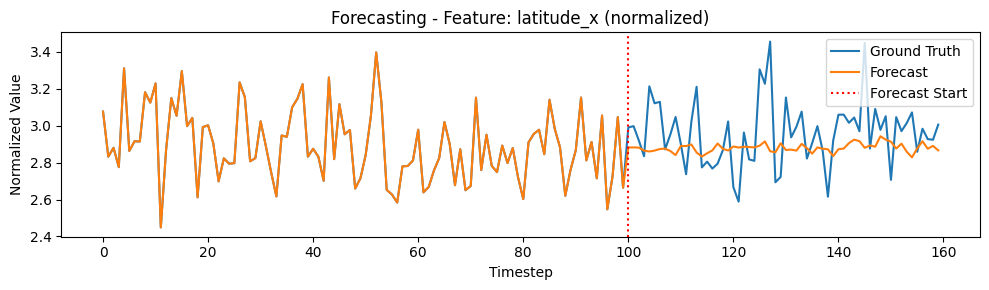

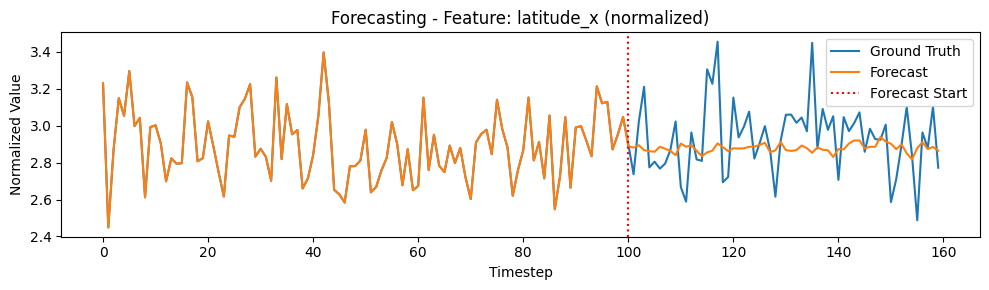

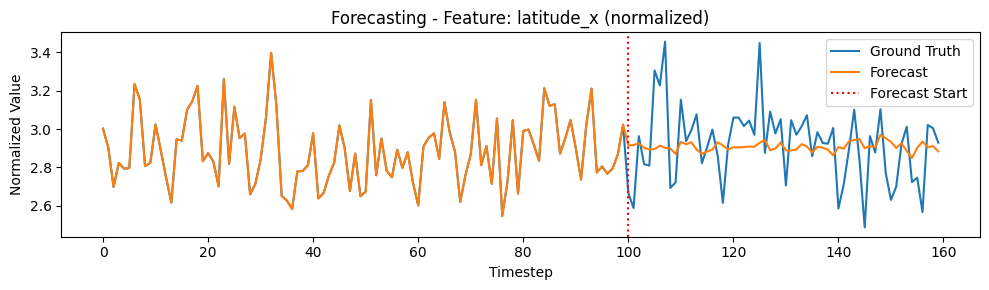

In [ ]:
plot_forecasts(
    model=model,
    val_loader=val_loader,
    device=device,
    scale_cols=scale_cols,      # Full list of feature names (even if not scaled)
    num_examples=3,
    feature_idx=0               # Index of the feature you want to visualize
)

In [ ]:
plot_forecasts(model, val_loader, device, scaler, scale_cols, feature_idx=0)

TypeError: '<' not supported between instances of 'int' and 'list'